<a href="https://colab.research.google.com/github/Nigosek/SNR/blob/master/zad2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [0]:
#tutaj się zaczyna coś co działa

# Podpinanie dysku google - to trzeba zrobic na początku, potem już tylko wszykot z wczytaniwania danych

In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
Wczytywanie danych

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!google-drive-ocamlfuse -cc

Clearing cache...done


In [0]:
cd /content/drive/snr_projekt/


/content/drive/snr_projekt


In [0]:
cd /content/snr

/content/snr


In [0]:
#cd /content/drive/snrApp/

In [0]:
 ls -la

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
ls: cannot open directory '.': No such file or directory


In [0]:
import os
from collections import Counter

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from skimage import feature
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

from keras.applications.vgg16 import VGG16
# from keras.preprocessing.image import load_img
from keras import layers
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation, InputLayer
from matplotlib import pyplot
from skimage.util import random_noise



Using TensorFlow backend.


In [0]:
def check_numpy_set_exist(name):
    if os.path.isfile("dataX-" + name + ".npy") and os.path.isfile("dataY-" + name + ".npy"):
        return True
    return False

In [0]:
def load_numpy_set(name):
    x = np.load("dataX-" + name + ".npy")
    y = np.load("dataY-" + name + ".npy")
    return x, y

In [0]:
def make_id_class_dictionary(y_val):
    # make dictionary of classes
    y_val.sort()
    y_val = Counter(y_val).keys()

    class_id = {}
    temp_list_id = []
    count = 1

    for i in y_val:
        temp_list_id.append((i, count))
        count += 1

    for word, _id in temp_list_id:
        class_id[word] = _id
    print(class_id)

    return class_id

In [0]:
def cvt2_id_class_list(dictionary_class_id, word_list):
    # covert word list of class to id list of class
    y_teach = []
    for i in word_list:
        y_teach.append(dictionary_class_id[i])
    return y_teach

In [0]:
def cv2_id_class_as_vector(y_val_temp, num_of_class):
    y_val = []
    for i in y_val_temp:
        y = [0] * num_of_class
        y[i - 1] = 1
        y_val.append(y)
    np.asarray(y_val)
    return y_val

In [0]:
# def conv():
#     if not check_numpy_set_exist("teach"):
#         create_numpy_set(TRAINING_PATH, "teach")
#     x_teach, y_teach = load_numpy_set("teach")
#     if not check_numpy_set_exist("test"):
#         create_numpy_set(TEST_PATH, "test")
#     x_test_temp, y_test_temp = load_numpy_set("test")
#     y_test_temp_copy = y_test_temp.copy()

#     # random Split Data set to teach
#     x_teach, x_val, y_teach_temp1, y_val_temp1 = train_test_split(x_teach, y_teach, test_size=0.3, random_state=42)

#     # number of class in set
#     num_of_class = len(set(y_test_temp_copy))

#     # make idClasses
#     id_class_dictionary = make_id_class_dictionary(y_test_temp_copy)

#     # convert from wordList to numberList Of class
#     y_teach_temp2 = cvt2_id_class_list(id_class_dictionary, y_teach_temp1)
#     y_val_temp2 = cvt2_id_class_list(id_class_dictionary, y_val_temp1)

#     # get final representation of labels as vector ex. [0 0 0 0 ..... 0 1 0 0 0] - outputs of network
#     y_val = cv2_id_class_as_vector(y_val_temp2, num_of_class)
#     y_teach = cv2_id_class_as_vector(y_teach_temp2, num_of_class)

#     vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

#     for layer in vgg_conv.layers[:-4]:
#         layer.trainable = False

#     # Tworzenie nowego modelu
#     model = Sequential()
#     model.add(vgg_conv)

#     # Dodawanie warstw
#     model.add(layers.Flatten())
#     model.add(layers.Dense(72, activation='softmax'))


#     # Schemat modelu
#     model.summary()

#     # NUM_OF_EPOCH = 50
#     # BATH_SIZE = 1000

#     # Konfiguracja sieci i danych
#     model.compile(loss='categorical_crossentropy',
#                   optimizer='adam',
#                   # optimizers.adam(lr=0.0001),
#                   metrics=['categorical_accuracy'])
#     results = model.fit(x_teach, np.asarray(y_teach), epochs=NUM_OF_EPOCH, batch_size=BATH_SIZE, validation_data=(x_val, np.asarray(y_val)),
#                         verbose=1)


In [0]:
# if not check_numpy_set_exist("teach"):
#   create_numpy_set(TRAINING_PATH, "teach")
#   print("Dane trengowe tworzone")
print("Dane trengowe wczytywanie rozpoczęte")
x_teach, y_teach = load_numpy_set("teach")
print("Dane trengowe wczytane")
# if not check_numpy_set_exist("test"):
#   create_numpy_set(TEST_PATH, "test")
#   print("Dane testowe tworzone")
  
print("Dane testowe wczytywanie rozpoczęte")
x_test, y_test_temp = load_numpy_set("test")
print("Dane testowe wczytane")
y_test_temp_copy = y_test_temp.copy()

# random Split Data set to teach
x_teach, x_val, y_teach_temp1, y_val_temp1 = train_test_split(x_teach, y_teach, test_size=0.3, random_state=42)
print("Dane podzielone na zbiór trteningowy i walidacyjny")

# number of class in set
num_of_class = len(set(y_test_temp_copy))

# make idClasses
id_class_dictionary = make_id_class_dictionary(y_test_temp_copy)

# convert from wordList to numberList Of class
y_teach_temp2 = cvt2_id_class_list(id_class_dictionary, y_teach_temp1)
y_val_temp2 = cvt2_id_class_list(id_class_dictionary, y_val_temp1)

# get final representation of labels as vector ex. [0 0 0 0 ..... 0 1 0 0 0] - outputs of network
y_val = cv2_id_class_as_vector(y_val_temp2, num_of_class)
y_teach = cv2_id_class_as_vector(y_teach_temp2, num_of_class)


#zbiór testowy
y_test_tmp = cvt2_id_class_list(id_class_dictionary, y_test_temp)
y_test = cv2_id_class_as_vector(y_test_tmp, num_of_class)
#zmiana nazw zbioru testowego
# x_test = x_test_temp


Dane trengowe wczytywanie rozpoczęte
Dane trengowe wczytane
Dane testowe wczytywanie rozpoczęte
Dane testowe wczytane
Dane podzielone na zbiór trteningowy i walidacyjny
{'Apple Braeburn': 1, 'Apple Golden': 2, 'Apple Granny Smith': 3, 'Apple Red': 4, 'Apple Red Delicious': 5, 'Apple Red Yellow': 6, 'Apricot': 7, 'Avocado': 8, 'Avocado ripe': 9, 'Banana': 10, 'Banana Red': 11, 'Cactus fruit': 12, 'Cantaloupe': 13, 'Carambula': 14, 'Cherry': 15, 'Cherry Rainier': 16, 'Cherry Wax Black': 17, 'Cherry Wax Red': 18, 'Cherry Wax Yellow': 19, 'Clementine': 20, 'Cocos': 21, 'Dates': 22, 'Granadilla': 23, 'Grape Pink': 24, 'Grape White': 25, 'Grapefruit Pink': 26, 'Grapefruit White': 27, 'Guava': 28, 'Huckleberry': 29, 'Kaki': 30, 'Kiwi': 31, 'Kumquats': 32, 'Lemon': 33, 'Lemon Meyer': 34, 'Limes': 35, 'Lychee': 36, 'Mandarine': 37, 'Mango': 38, 'Maracuja': 39, 'Melon Piel de Sapo': 40, 'Mulberry': 41, 'Nectarine': 42, 'Orange': 43, 'Papaya': 44, 'Passion Fruit': 45, 'Peach': 46, 'Peach Flat': 4

# 2a  zaimplementować dowolnie wybraną przez siebie głęboką sieć splotową - bez uczenia - wagi zaincjalizowane z "imagenet"

In [0]:
filepath_not_trained="best_VGG_based_model_no_trained.hdf5"

In [0]:
x_test_temp=x_test

In [0]:

vgg_conv_not_trained = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
model_not_trained = Sequential()
model_not_trained.add(vgg_conv_not_trained)
# # Dodawanie warstw
model_not_trained.add(layers.Flatten())
model_not_trained.add(layers.Dense(71, activation='softmax'))
# Schemat modelu
model_not_trained.summary()

model_not_trained.compile(loss='categorical_crossentropy',
#               optimizer='adam',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['categorical_accuracy'])

# checkpoint_not_trained = ModelCheckpoint(filepath_not_trained, verbose=0, save_best_only=True)
# cb_not_trained = [checkpoint_not_trained] 

# NUM_OF_EPOCH_not_trained = 1
# BATH_SIZE_not_trained = 100

print(model_not_trained.metrics_names)
print(model_not_trained.evaluate(x_val, np.asarray(y_val)))
print(model_not_trained.evaluate(x_test_temp, np.asarray(y_test)))
# results_not_trained = model_not_trained.fit(x_teach, np.asarray(y_teach), epochs=NUM_OF_EPOCH_not_trained, batch_size=BATH_SIZE_not_trained, validation_data=(x_val, np.asarray(y_val)),
#                     verbose=1,callbacks= cb_not_trained)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 71)                327239    
Total params: 15,041,927
Trainable params: 15,041,927
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 4608)              0         
________________________________________________________________

In [0]:
model_not_trained.save(filepath_not_trained)

###z randomowo zaincjanizowanymi wagami:

In [0]:
vgg_conv_not_trained_rand = VGG16(weights=None, include_top=False, input_shape=(100, 100, 3))
model_not_trained_rand = Sequential()
model_not_trained_rand.add(vgg_conv_not_trained_rand)
# # Dodawanie warstw
model_not_trained_rand.add(layers.Flatten())
model_not_trained_rand.add(layers.Dense(71, activation='softmax'))
# Schemat modelu
model_not_trained_rand.summary()

model_not_trained_rand.compile(loss='categorical_crossentropy',
#               optimizer='adam',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['categorical_accuracy'])

# checkpoint_not_trained = ModelCheckpoint(filepath_not_trained, verbose=0, save_best_only=True)
# cb_not_trained = [checkpoint_not_trained] 

# NUM_OF_EPOCH_not_trained = 1
# BATH_SIZE_not_trained = 100

print(model_not_trained_rand.metrics_names)
print(model_not_trained_rand.evaluate(x_val, np.asarray(y_val)))
print(model_not_trained_rand.evaluate(x_test_temp, np.asarray(y_test)))
# results_not_trained = model_not_trained.fit(x_teach, np.asarray(y_teach), epochs=NUM_OF_EPOCH_not_trained, batch_size=BATH_SIZE_not_trained, validation_data=(x_val, np.asarray(y_val)),
#                     verbose=1,callbacks= cb_not_trained)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 71)                327239    
Total params: 15,041,927
Trainable params: 15,041,927
Non-trainable params: 0
_________________________________________________________________
['loss', 'categorical_accuracy']
12397/12397 [==============================] - 31s 2ms/step
[4.42519300145719, 0.012664354279261112]
13877/13877 [==============================] - 33s 2ms/step
[4.44697113879658, 0.011818116307559271]


In [0]:
filepath_not_trained_rand="best_VGG_based_model_no_trained_rand.hdf5"

In [0]:
model_not_trained_rand.save(filepath_not_trained_rand)

# 2b  zaimplementować dowolnie wybraną przez siebie głęboką sieć splotową - z uczeniem

In [0]:
NUM_OF_EPOCH = 2
BATH_SIZE = 100
filepath="best_VGG_based_model_01.hdf5"

In [0]:
# vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
vgg_conv = VGG16(weights=None, include_top=False, input_shape=(100, 100, 3))

# for layer in vgg_conv.layers[:-4]:
#     layer.trainable = False

# Tworzenie nowego modelu
model = Sequential()
model.add(vgg_conv)

# Dodawanie warstw
model.add(layers.Flatten())
model.add(layers.Dense(71, activation='softmax'))


# Schemat modelu
model.summary()

# NUM_OF_EPOCH = 50
# BATH_SIZE = 1000

# Konfiguracja sieci i danych
model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['categorical_accuracy'])

# filepath="best_VGG_based_model_01.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=0, save_best_only=True)
cb = [checkpoint] 

# results = model.fit(x_teach, np.asarray(y_teach), epochs=NUM_OF_EPOCH, batch_size=BATH_SIZE, validation_data=(x_val, np.asarray(y_val)),
#                     verbose=1,callbacks= cb)
results = model.fit(x_teach, np.asarray(y_teach), epochs=NUM_OF_EPOCH, batch_size=BATH_SIZE, validation_data=(x_test, np.asarray(y_test)),
                    verbose=1,callbacks= cb)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 71)                327239    
Total params: 15,041,927
Trainable params: 15,041,927
Non-trainable params: 0
_________________________________________________________________
Train on 28925 samples, validate on 13877 samples
Epoch 1/2
28925/28925 [==============================] - 227s 8ms/step - loss: 0.7450 - categorical_accuracy: 0.8041 - val_loss: 0.4341 - val_categorical_accuracy: 0.9181
Epoch 2/2
28925/28925 [==============================] - 212s 7ms/step - loss: 0.0538 - categorical_accuracy: 0.9851 - val_loss: 0.1158 - val_categorical_accuracy: 0.9695


In [0]:
#Wczytanie wersji modelu, która osiągała najlepsze wyniki w trakcie szkolenia
best_vgg_model = load_model(filepath)

In [0]:
# y_test_tmp = cvt2_id_class_list(id_class_dictionary, y_test_temp)
# y_test = cv2_id_class_as_vector(y_test_tmp, num_of_class)

In [0]:
print ('Start evaluating')
evaluation_result = best_vgg_model.evaluate(x_test_temp, np.asarray(y_test))
print ('Finish evaluating:')
print(best_vgg_model.metrics_names)
print(evaluation_result)

Start evaluating
13877/13877 [==============================] - 35s 3ms/step
Finish evaluating:
['loss', 'categorical_accuracy']
[0.33495797395142246, 0.9188585429213237]


# 2c wykonać zwielokrotnianie danych

##  Obroty

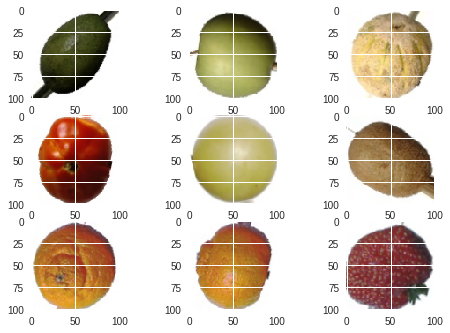

In [0]:
# obroty
datagennewnew_rot = ImageDataGenerator(rotation_range=90,
                                  fill_mode='nearest')
datagennewnew_rot.fit(x_teach)
for X_batch, y_batch in datagennewnew_rot.flow(x_teach, y_teach, batch_size=9):
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        bgr = X_batch[i].reshape(100, 100, 3).astype('uint8')
        rgb = bgr[...,::-1]
        pyplot.imshow(rgb)
    pyplot.show()
    break

'/content/snr'

In [0]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
# Tworzenie nowego modelu
model = Sequential()
model.add(vgg_conv)

# Dodawanie warstw
model.add(layers.Flatten())
model.add(layers.Dense(71, activation='softmax'))

# Schemat modelu
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 71)                327239    
Total params: 15,041,927
Trainable params: 15,041,927
Non-trainable params: 0
_________________________________________________________________


In [0]:

#datagennewnew_rot = ImageDataGenerator(rotation_range=90,
#                                      fill_mode='nearest')
#datagennewnew_rot.fit(x_teach)
traind_data_generator = datagennewnew_rot.flow(x_teach, np.array(y_teach), batch_size=100)

# Konfiguracja sieci i danych
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['categorical_accuracy'])




# results = model.fit(traind_data_generator, epochs=1, batch_size=200, validation_data=(x_test, np.asarray(y_test)), verbose=1)
# results = model.fit(traind_data_generator, steps_per_epoch=len(x_teach) / 100, epochs=1, verbose=1)
results = model.fit_generator(traind_data_generator, steps_per_epoch=len(x_teach) / 100, epochs=3,validation_data=(x_test, np.asarray(y_test)), verbose=1)

# for X_batch, y_batch in datagennewnew_rot.flow(x_teach, y_teach, batch_size=9):
#     for i in range(0, 9):
#         pyplot.subplot(330 + 1 + i)
#         pyplot.imshow(X_batch[i].reshape(100, 100, 3).astype('uint8'))
#     pyplot.show()
#     break

Epoch 1/3
290/289 [==============================] - 241s 832ms/step - loss: 1.4589 - categorical_accuracy: 0.6816 - val_loss: 0.2223 - val_categorical_accuracy: 0.9328
Epoch 2/3
290/289 [==============================] - 229s 790ms/step - loss: 0.0774 - categorical_accuracy: 0.9766 - val_loss: 0.1434 - val_categorical_accuracy: 0.9595
Epoch 3/3
290/289 [==============================] - 229s 790ms/step - loss: 0.0553 - categorical_accuracy: 0.9825 - val_loss: 0.0445 - val_categorical_accuracy: 0.9853


In [0]:
file_path_2_save_file="best_VGG_based_model_rotated_images.hdf5"
model.save(file_path_2_save_file)

In [0]:
# # here's a more "manual" example
# # datagennewnew_rot = ImageDataGenerator(rotation_range=90,
# #                                   fill_mode='nearest')
# datagennewnew_rot = ImageDataGenerator(fill_mode='nearest')
# datagennewnew_rot.fit(x_teach)

# # Konfiguracja sieci i danych
# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizers.Adam(lr=0.0001),
#               metrics=['categorical_accuracy'])

# epochs = 1
# for e in range(epochs):
#     print('Epoch', e)
#     batches = 0
#     for x_batch, y_batch in datagennewnew_rot.flow(x_teach, np.asarray(y_teach), batch_size=1000):
#         model.fit(x_batch, np.asarray(y_batch), batch_size = 100, validation_data=(x_test, np.asarray(y_test)),verbose=1)
#         batches += 1
#         if batches >= len(x_teach) / 100:
#             # we need to break the loop by hand because
#             # the generator loops indefinitely
#             break

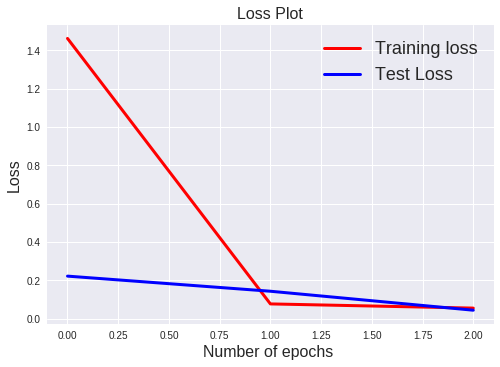

In [0]:
saveToFile = "rotated_loss"
# plt.figure(figsize=[8,6])
plt.plot(results.history['loss'],'r',linewidth=3.0)
plt.plot(results.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Test Loss'],fontsize=18)
plt.xlabel('Number of epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Plot',fontsize=16)
plt.savefig("wykresy/" + saveToFile)


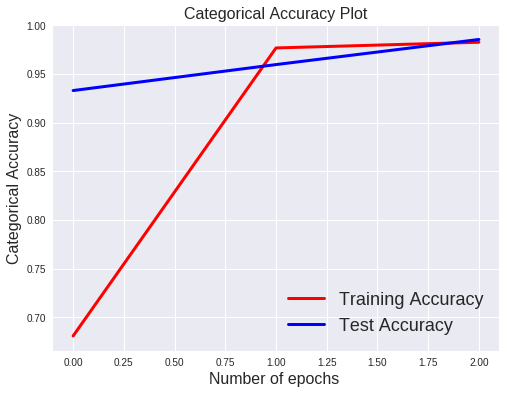

In [0]:
saveToFile = "rotated_accuracy"
plt.figure(figsize=[8,6])
plt.plot(results.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(results.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Test Accuracy'],fontsize=18)
plt.xlabel('Number of epochs ',fontsize=16)
plt.ylabel('Categorical Accuracy',fontsize=16)
plt.title('Categorical Accuracy Plot',fontsize=16)
plt.savefig("wykresy/" + saveToFile)

## Przesunięcie

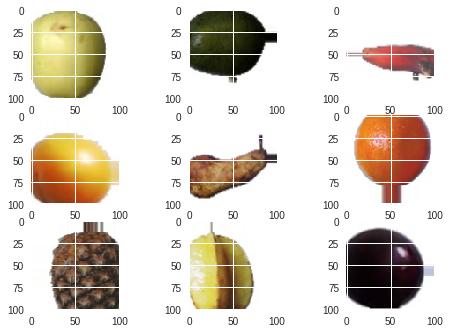

In [0]:
#przesunięcia
datagennewnew_shift = ImageDataGenerator(width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
datagennewnew_shift.fit(x_teach)
for X_batch, y_batch in datagennewnew_shift.flow(x_teach, y_teach, batch_size=9):
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        bgr = X_batch[i].reshape(100, 100, 3).astype('uint8')
        rgb = bgr[...,::-1]
        pyplot.imshow(rgb)
    pyplot.show()
    break

In [0]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
# Tworzenie nowego modelu
model = Sequential()
model.add(vgg_conv)

# Dodawanie warstw
model.add(layers.Flatten())
model.add(layers.Dense(71, activation='softmax'))

# Schemat modelu
model.summary()

58892288/58889256 [==============================] - 5s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 71)                327239    
Total params: 15,041,927
Trainable params: 15,041,927
Non-trainable params: 0
_________________________________________________________________


In [0]:
#datagennewnew_shift = ImageDataGenerator(width_shift_range=0.2,
#                                  height_shift_range=0.2,
#                                  fill_mode='nearest')
#datagennewnew_shift.fit(x_teach)
traind_data_generator = datagennewnew_shift.flow(x_teach, np.array(y_teach), batch_size=100)

# Konfiguracja sieci i danych
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),#0.0001
              metrics=['categorical_accuracy'])

results = model.fit_generator(traind_data_generator, steps_per_epoch=len(x_teach) / 100, epochs=2,validation_data=(x_test, np.asarray(y_test)), verbose=1)


Epoch 1/3
290/289 [==============================] - 230s 794ms/step - loss: 1.7774 - categorical_accuracy: 0.6120 - val_loss: 0.2249 - val_categorical_accuracy: 0.9300
Epoch 2/3
290/289 [==============================] - 219s 756ms/step - loss: 0.1007 - categorical_accuracy: 0.9659 - val_loss: 0.0485 - val_categorical_accuracy: 0.9863
Epoch 3/3
290/289 [==============================] - 219s 754ms/step - loss: 0.0490 - categorical_accuracy: 0.9851 - val_loss: 0.1582 - val_categorical_accuracy: 0.9550


In [0]:
file_path_2_save_file="best_VGG_based_model_shifted_images.hdf5"
model.save(file_path_2_save_file)

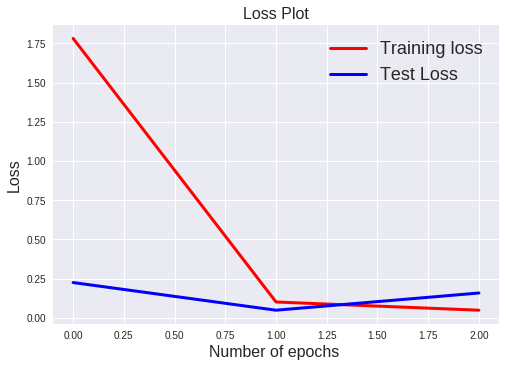

In [0]:
saveToFile = "shifted_loss"
# plt.figure(figsize=[8,6])
plt.plot(results.history['loss'],'r',linewidth=3.0)
plt.plot(results.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Test Loss'],fontsize=18)
plt.xlabel('Number of epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Plot',fontsize=16)
plt.savefig("wykresy/" + saveToFile)


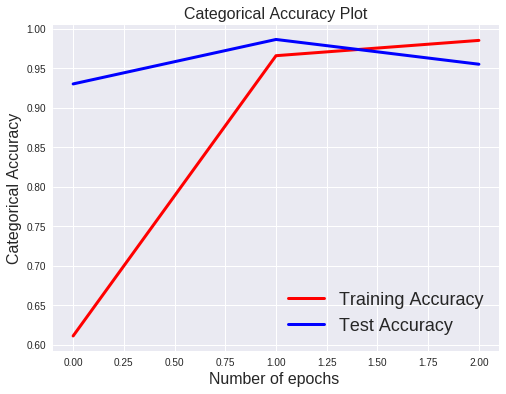

In [0]:
saveToFile = "shifted_accuracy"
plt.figure(figsize=[8,6])
plt.plot(results.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(results.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Test Accuracy'],fontsize=18)
plt.xlabel('Number of epochs ',fontsize=16)
plt.ylabel('Categorical Accuracy',fontsize=16)
plt.title('Categorical Accuracy Plot',fontsize=16)
plt.savefig("wykresy/" + saveToFile)

## noise gaussian

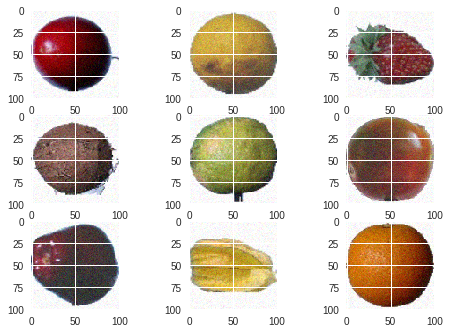

In [6]:
#noise gaussian
datagennewnew_noise = ImageDataGenerator(fill_mode='nearest')
x_teach_noise = np.copy(x_teach)

for x in range(0, x_teach_noise.shape[0]):
    imgtmp = (x_teach_noise[x]).astype(np.float32) / 255.0
    imgtmp = random_noise(imgtmp,mode='gaussian',var=0.05**2)
    imgtmp=imgtmp * 255.0
    imgtmp= imgtmp.astype(np.int)
    x_teach_noise[x] = imgtmp

datagennewnew_noise.fit(x_teach_noise)
for X_batch, y_batch in datagennewnew_noise.flow(x_teach_noise, y_teach, batch_size=9):
    for i in range(0, 9):
#         img = X_batch[i]
#         img/=255
#         img = random_noise(img,mode='gaussian',var=0.05**2)
#         img*=255
#         img = img.astype(np.int)
        pyplot.subplot(330 + 1 + i)
        bgr = X_batch[i].reshape(100, 100, 3).astype('uint8')
        rgb = bgr[...,::-1]
        pyplot.imshow(rgb)
    pyplot.show()
    break  

In [0]:
# #noise gaussian
# datagennewnew_noise = ImageDataGenerator(fill_mode='nearest')
# x_teach_noise = np.copy(x_teach)
# datagennewnew_noise.fit(x_teach_noise)
# for image in x_teach_noise:
#   image/=255
#   image = random_noise(img,mode='gaussian',var=0.05**2)
#   image*=255
#   image = img.astype(np.int)

# for X_batch, y_batch in datagennewnew_noise.flow(x_teach_noise, y_teach, batch_size=9):
#     for i in range(0, 9):
#         img = X_batch[i]
#         img/=255
#         img = random_noise(img,mode='gaussian',var=0.05**2)
#         img*=255
#         img = img.astype(np.int)
#         pyplot.subplot(330 + 1 + i)
#         pyplot.imshow(img.reshape(100, 100, 3).astype('uint8'))
#     pyplot.show()
#     break

In [7]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
# Tworzenie nowego modelu
model = Sequential()
model.add(vgg_conv)

# Dodawanie warstw
model.add(layers.Flatten())
model.add(layers.Dense(71, activation='softmax'))

# Schemat modelu
model.summary()

58892288/58889256 [==============================] - 6s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 71)                327239    
Total params: 15,041,927
Trainable params: 15,041,927
Non-trainable params: 0
_________________________________________________________________


In [8]:
# datagennewnew_noise = ImageDataGenerator(fill_mode='nearest')

# datagennewnew_noise.fit(x_teach)
traind_data_generator = datagennewnew_noise.flow(x_teach, np.array(y_teach), batch_size=100)

# Konfiguracja sieci i danych
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LR_ADAMA),
              metrics=['categorical_accuracy'])

results = model.fit_generator(traind_data_generator, steps_per_epoch=len(x_teach) / 100, epochs=10,validation_data=(x_test, np.asarray(y_test)), verbose=1)


Epoch 1/10
290/289 [==============================] - 245s 844ms/step - loss: 1.6268 - categorical_accuracy: 0.6600 - val_loss: 0.4805 - val_categorical_accuracy: 0.8552
Epoch 2/10
290/289 [==============================] - 239s 824ms/step - loss: 0.0536 - categorical_accuracy: 0.9837 - val_loss: 0.1557 - val_categorical_accuracy: 0.9520
Epoch 3/10
290/289 [==============================] - 225s 778ms/step - loss: 0.0052 - categorical_accuracy: 0.9987 - val_loss: 0.0446 - val_categorical_accuracy: 0.9878
Epoch 4/10
290/289 [==============================] - 225s 775ms/step - loss: 4.8486e-05 - categorical_accuracy: 1.0000 - val_loss: 0.0466 - val_categorical_accuracy: 0.9871
Epoch 5/10
290/289 [==============================] - 224s 773ms/step - loss: 2.5987e-05 - categorical_accuracy: 1.0000 - val_loss: 0.0427 - val_categorical_accuracy: 0.9880
Epoch 6/10
290/289 [==============================] - 224s 771ms/step - loss: 1.7200e-05 - categorical_accuracy: 1.0000 - val_loss: 0.0444 - v

In [0]:
path_file_gaussian_noise="best_VGG_based_model_gauss.hdf5"#przeuczona
model.save(path_file_gaussian_noise)

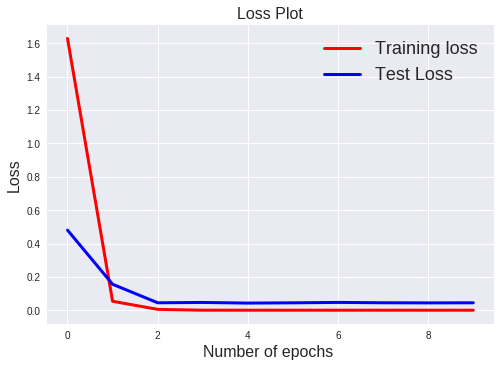

In [9]:
saveToFile = "gaussian_noise_loss10"
# plt.figure(figsize=[8,6])
plt.plot(results.history['loss'],'r',linewidth=3.0)
plt.plot(results.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Test Loss'],fontsize=18)
plt.xlabel('Number of epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Plot',fontsize=16)
plt.savefig("wykresy/" + saveToFile)


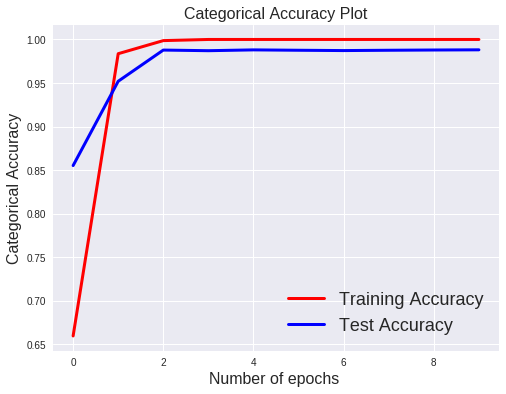

In [10]:
saveToFile = "gaussian_noise_accuracy10"
plt.figure(figsize=[8,6])
plt.plot(results.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(results.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Test Accuracy'],fontsize=18)
plt.xlabel('Number of epochs ',fontsize=16)
plt.ylabel('Categorical Accuracy',fontsize=16)
plt.title('Categorical Accuracy Plot',fontsize=16)
plt.savefig("wykresy/" + saveToFile)

In [0]:
del vgg_conv 
del model

## noise s&p

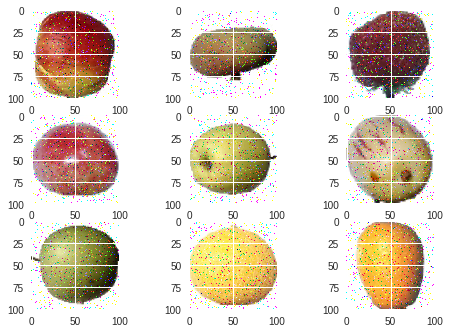

In [0]:
#noise s&p
datagennewnew_noise = ImageDataGenerator(fill_mode='nearest')
x_teach_noise = np.copy(x_teach)

for x in range(0, x_teach_noise.shape[0]):
    imgtmp = (x_teach_noise[x]).astype(np.float32) / 255.0
    imgtmp = random_noise(imgtmp,mode='s&p')
    imgtmp=imgtmp * 255.0
    imgtmp= imgtmp.astype(np.int)
    x_teach_noise[x] = imgtmp

datagennewnew_noise.fit(x_teach_noise)
for X_batch, y_batch in datagennewnew_noise.flow(x_teach_noise, y_teach, batch_size=9):
    for i in range(0, 9):
#         img = X_batch[i]
#         img/=255
#         img = random_noise(img,mode='gaussian',var=0.05**2)
#         img*=255
#         img = img.astype(np.int)
        pyplot.subplot(330 + 1 + i)
        bgr = X_batch[i].reshape(100, 100, 3).astype('uint8')
        rgb = bgr[...,::-1]
        pyplot.imshow(rgb)
    pyplot.show()
    break  

In [0]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
# Tworzenie nowego modelu
model = Sequential()
model.add(vgg_conv)

# Dodawanie warstw
model.add(layers.Flatten())
model.add(layers.Dense(71, activation='softmax'))

# Schemat modelu
model.summary()

58892288/58889256 [==============================] - 7s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 71)                327239    
Total params: 15,041,927
Trainable params: 15,041,927
Non-trainable params: 0
_________________________________________________________________


In [0]:
# datagennewnew_noise = ImageDataGenerator(fill_mode='nearest')

# datagennewnew_noise.fit(x_teach)
traind_data_generator = datagennewnew_noise.flow(x_teach, np.array(y_teach), batch_size=100)

# Konfiguracja sieci i danych
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LR_ADAMA),#125
              metrics=['categorical_accuracy'])

results = model.fit_generator(traind_data_generator, steps_per_epoch=len(x_teach) / 100, epochs=3,validation_data=(x_test, np.asarray(y_test)), verbose=1)


Epoch 1/3
290/289 [==============================] - 236s 813ms/step - loss: 1.7055 - categorical_accuracy: 0.6396 - val_loss: 0.4106 - val_categorical_accuracy: 0.8771
Epoch 2/3
290/289 [==============================] - 231s 796ms/step - loss: 0.0567 - categorical_accuracy: 0.9826 - val_loss: 0.3096 - val_categorical_accuracy: 0.9138
Epoch 3/3
290/289 [==============================] - 217s 748ms/step - loss: 0.0227 - categorical_accuracy: 0.9932 - val_loss: 0.0629 - val_categorical_accuracy: 0.9793


TUTAJ ZACZNIJ

In [0]:
path_file_sp_noise="best_VGG_based_model_sp.hdf5"#przeuczona
model.save(path_file_sp_noise)

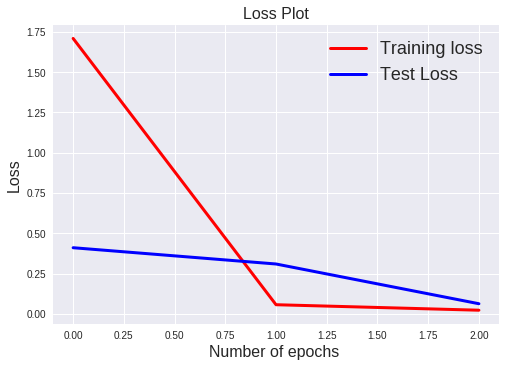

In [0]:
saveToFile = "sp_noise_loss"
# plt.figure(figsize=[8,6])
plt.plot(results.history['loss'],'r',linewidth=3.0)
plt.plot(results.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Test Loss'],fontsize=18)
plt.xlabel('Number of epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Plot',fontsize=16)
plt.savefig("wykresy/" + saveToFile)


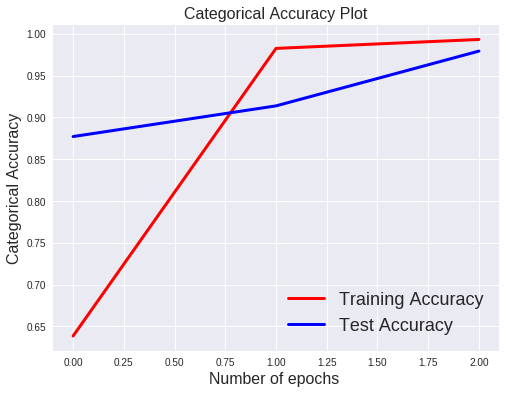

In [0]:
saveToFile = "sp_noise_accuracy"
plt.figure(figsize=[8,6])
plt.plot(results.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(results.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Test Accuracy'],fontsize=18)
plt.xlabel('Number of epochs ',fontsize=16)
plt.ylabel('Categorical Accuracy',fontsize=16)
plt.title('Categorical Accuracy Plot',fontsize=16)
plt.savefig("wykresy/" + saveToFile)

In [0]:
# #noise s&p
# datagennewnew_noise = ImageDataGenerator(fill_mode='nearest')
# x_teach_noise = np.copy(x_teach)

# for image in x_teach_noise:
#     type(image)
#     image=image / 255
#     image = random_noise(image,mode='s&p')
#     image*=255
#     image = image.astype(np.int)

# datagennewnew_noise.fit(x_teach_noise)
# for X_batch, y_batch in datagennewnew_noise.flow(x_teach_noise, y_teach, batch_size=9):
#     for i in range(0, 9):
# #         img = X_batch[i]
# #         img/=255
# #         img = random_noise(img,mode='gaussian',var=0.05**2)
# #         img*=255
# #         img = img.astype(np.int)
#         pyplot.subplot(330 + 1 + i)
#         pyplot.imshow(X_batch[i].reshape(100, 100, 3).astype('uint8'))
#     pyplot.show()
#     break  

In [0]:
# #noise s&p
# datagennewnew_noise = ImageDataGenerator(fill_mode='nearest')
# datagennewnew_noise.fit(x_teach)
# for X_batch, y_batch in datagennewnew_noise.flow(x_teach, y_teach, batch_size=9):
#     for i in range(0, 9):
#         img = X_batch[i]
#         img/=255
#         img = random_noise(img,mode='s&p')
#         img*=255
#         img = img.astype(np.int)
#         pyplot.subplot(330 + 1 + i)
#         pyplot.imshow(img.reshape(100, 100, 3).astype('uint8'))
#     pyplot.show()
#     break

In [0]:
del datagennewnew_noise

## noise speckle

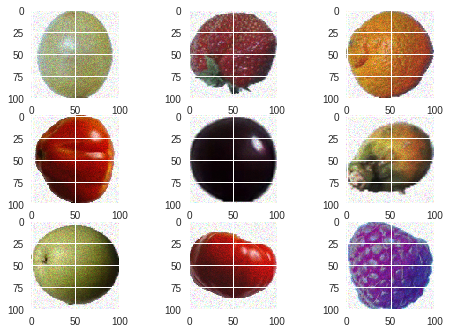

In [0]:
#noise s&p
datagennewnew_noise = ImageDataGenerator(fill_mode='nearest')
x_teach_noise = np.copy(x_teach)

for x in range(0, x_teach_noise.shape[0]):
    imgtmp = (x_teach_noise[x]).astype(np.float32) / 255.0
    imgtmp = random_noise(imgtmp,mode='speckle')
    imgtmp=imgtmp * 255.0
    imgtmp= imgtmp.astype(np.int)
    x_teach_noise[x] = imgtmp

datagennewnew_noise.fit(x_teach_noise)
for X_batch, y_batch in datagennewnew_noise.flow(x_teach_noise, y_teach, batch_size=9):
    for i in range(0, 9):
#         img = X_batch[i]
#         img/=255
#         img = random_noise(img,mode='gaussian',var=0.05**2)
#         img*=255
#         img = img.astype(np.int)
        pyplot.subplot(330 + 1 + i)
        bgr = X_batch[i].reshape(100, 100, 3).astype('uint8')
        rgb = bgr[...,::-1]
        pyplot.imshow(rgb)
    pyplot.show()
    break  

In [0]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
# Tworzenie nowego modelu
model = Sequential()
model.add(vgg_conv)

# Dodawanie warstw
model.add(layers.Flatten())
model.add(layers.Dense(71, activation='softmax'))

# Schemat modelu
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 71)                327239    
Total params: 15,041,927
Trainable params: 15,041,927
Non-trainable params: 0
_________________________________________________________________


In [0]:
# datagennewnew_noise = ImageDataGenerator(fill_mode='nearest')

# datagennewnew_noise.fit(x_teach)
traind_data_generator = datagennewnew_noise.flow(x_teach, np.array(y_teach), batch_size=100)

# Konfiguracja sieci i danych
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['categorical_accuracy'])

results = model.fit_generator(traind_data_generator, steps_per_epoch=len(x_teach) / 100, epochs=1,validation_data=(x_test, np.asarray(y_test)), verbose=1)


Epoch 1/1
290/289 [==============================] - 233s 803ms/step - loss: 2.0363 - categorical_accuracy: 0.7174 - val_loss: 0.2167 - val_categorical_accuracy: 0.9304


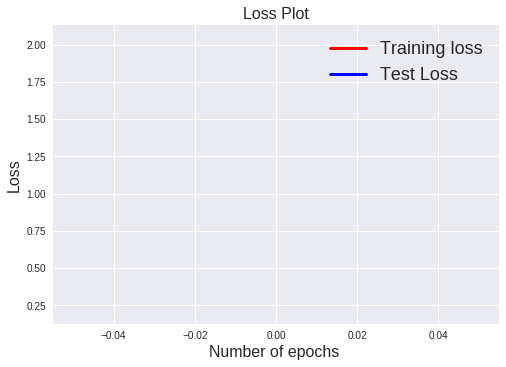

In [0]:
saveToFile = "robocza_nazwa_loss"
# plt.figure(figsize=[8,6])
plt.plot(results.history['loss'],'r',linewidth=3.0)
plt.plot(results.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Test Loss'],fontsize=18)
plt.xlabel('Number of epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Plot',fontsize=16)
plt.savefig("wykresy/" + saveToFile)


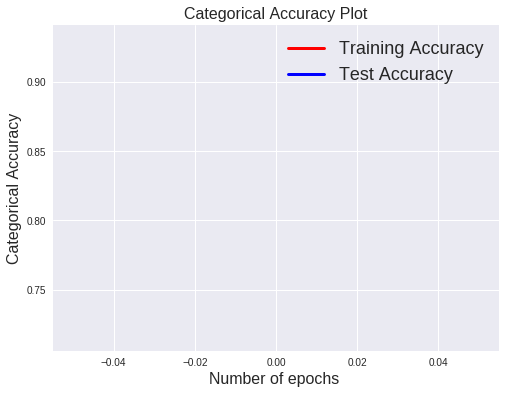

In [0]:
saveToFile = "robocza_nazwa_accuracy"
plt.figure(figsize=[8,6])
plt.plot(results.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(results.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Test Accuracy'],fontsize=18)
plt.xlabel('Number of epochs ',fontsize=16)
plt.ylabel('Categorical Accuracy',fontsize=16)
plt.title('Categorical Accuracy Plot',fontsize=16)
plt.savefig("wykresy/" + saveToFile)

In [0]:
# #noise speckle
# datagennewnew_noise = ImageDataGenerator(fill_mode='nearest')
# datagennewnew_noise.fit(x_teach)
# for X_batch, y_batch in datagennewnew_noise.flow(x_teach, y_teach, batch_size=9):
#     for i in range(0, 9):
#         img = X_batch[i]
#         img/=255
#         img = random_noise(img,mode='speckle')
#         img*=255
#         img = img.astype(np.int)
#         pyplot.subplot(330 + 1 + i)
#         pyplot.imshow(img.reshape(100, 100, 3).astype('uint8'))
#     pyplot.show()
#     break

In [0]:
# # x_teach, x_val, y_teach_temp1, y_val_temp1 
# datagennewnew = ImageDataGenerator()
# datagennewnew.fit(x_teach)
# # X_batch = datagennewnew.flow(x_teach, y_teach, batch_size=32)

# for X_batch, y_batch in datagennewnew.flow(x_teach, y_teach, batch_size=9):
# 	# create a grid of 3x3 images
# 	for i in range(0, 9):
#     pyplot.subplot(330 + 1 + i)
#     pyplot.imshow(X_batch[i].reshape(100, 100, 3).astype('uint8'))
    
# # 	   pyplot.subplot(330 + 1 + i)
# #       imshow(X_batch[i].reshape(100, 100,3).astype('uint8'))
#     #cmap=pyplot.get_cmap('gray')
  

# # 		pyplot.imshow(X_batch[i].reshape(100, 100,3) ,cmap="gray", vmin = 0, vmax = 1)
# #     cvtColor(X_batch[i].reshape(100, 100,3))
# 	# show the plot
# 	pyplot.show()
# 	break


In [0]:
# best_vgg_model_extra_data = load_model(filepath)
# best_vgg_model_extra_data.fit_generator(datagennewnew.flow(x_teach, y_teach, batch_size=32),
#                     steps_per_epoch=len(x_teach) / 32,
#                             validation_data=(x_val, np.asarray(y_val)))

# Rozmiary deskryptora

In [0]:
# vgg_conv_info = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

In [0]:
# #rozmiar deskryptora
# tmp_model_working = Sequential()


# for tmp in vgg_conv_info.layers[:-2]:
#   tmp_model_working.add(tmp)

# # trzy różne rozmairy deskryptora
# # tmp_model_working.add(Convolution2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
# # tmp_model_working.add(Convolution2D(512, (5, 5), strides=(1, 1), padding='same', activation='relu'))
# tmp_model_working.add(Convolution2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))

# tmp_model_working.add(MaxPooling2D(pool_size=(2, 2),strides= (2, 2)))

# # # Dodawanie warstw
# tmp_model_working.add(layers.Flatten())
# tmp_model_working.add(layers.Dense(71, activation='softmax'))

# tmp_model_working.summary()

In [0]:
model = Sequential()

model.add(layers.InputLayer((100, 100, 3)))
model.add(layers.Convolution2D(64, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block1_conv1'))
model.add( layers.Convolution2D(64, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block1_conv2'))
model.add( layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

# Block 2
model.add( layers.Convolution2D(128, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block2_conv1'))
model.add( layers.Convolution2D(128, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block2_conv2'))
model.add( layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

# Block 3
model.add( layers.Convolution2D(256, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block3_conv1'))
model.add( layers.Convolution2D(256, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block3_conv2'))
model.add( layers.Convolution2D(256, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block3_conv3'))
model.add( layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

# Block 4
model.add( layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block4_conv1'))
model.add( layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block4_conv2'))
model.add( layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block4_conv3'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

# Block 5
model.add(layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block5_conv1'))
model.add(layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block5_conv2'))


# na tej warstwie trzeba coś modyfikować
model.add( layers.Convolution2D(64, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block5_conv3'))

# trzy różne rozmairy deskryptora zminiamy w tej warstwie powyżej "block5_conv3"
# model.add(layers.Convolution2D(64, (3, 3),
#                          activation='relu',
#                          padding='same',
#                          name='block5_conv3'))
# model.add(layers.Convolution2D(512, (5, 5),
#                          activation='relu',
#                          padding='same',
#                          name='block5_conv3'))
# model.add(layers.Convolution2D(512, (3, 3),
#                          activation='relu',
#                          padding='same',
#                          name='block5_conv3'))
###########################################


# tmp_model_working.add(Convolution2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
# tmp_model_working.add(Convolution2D(512, (5, 5), strides=(1, 1), padding='same', activation='relu'))
# tmp_model_working.add(Convolution2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))


model.add( layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

model.add(layers.Flatten())

model.add(layers.Dense(71, activation='softmax'))



model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 25, 25, 256)       295168    
__________

In [0]:
# Konfiguracja sieci i danych
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['categorical_accuracy'])

results = model.fit(x_teach, np.asarray(y_teach), epochs=2, steps_per_epoch=len(x_teach) / 100, validation_data=(x_test, np.asarray(y_test)),
                    verbose=1)



Train on 28925 samples, validate on 13877 samples
Epoch 1/1
28925/28925 [==============================] - 203s 7ms/step - loss: 0.7781 - categorical_accuracy: 0.7995 - val_loss: 0.5619 - val_categorical_accuracy: 0.8637


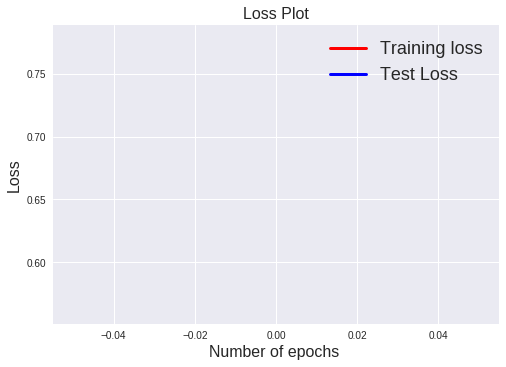

In [0]:
saveToFile = "robocza_nazwa_loss"
# plt.figure(figsize=[8,6])
plt.plot(results.history['loss'],'r',linewidth=3.0)
plt.plot(results.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Test Loss'],fontsize=18)
plt.xlabel('Number of epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Plot',fontsize=16)
plt.savefig("wykresy/" + saveToFile)


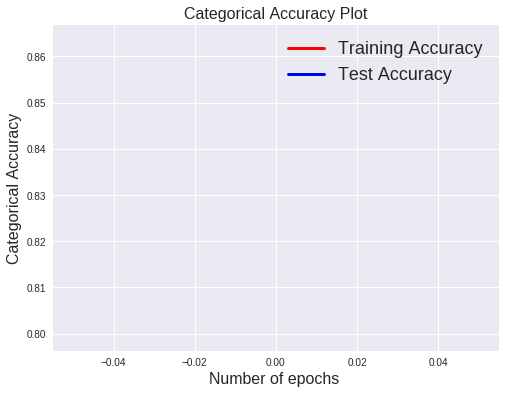

In [0]:
saveToFile = "robocza_nazwa_accuracy"
plt.figure(figsize=[8,6])
plt.plot(results.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(results.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Test Accuracy'],fontsize=18)
plt.xlabel('Number of epochs ',fontsize=16)
plt.ylabel('Categorical Accuracy',fontsize=16)
plt.title('Categorical Accuracy Plot',fontsize=16)
plt.savefig("wykresy/" + saveToFile)

# Dropout

In [0]:
model = Sequential()

model.add(layers.InputLayer((100, 100, 3)))
model.add(layers.Convolution2D(64, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block1_conv1'))
model.add( layers.Convolution2D(64, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block1_conv2'))
model.add( layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

# Block 2
model.add( layers.Convolution2D(128, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block2_conv1'))
model.add( layers.Convolution2D(128, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block2_conv2'))
model.add( layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

# Block 3
model.add( layers.Convolution2D(256, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block3_conv1'))
model.add( layers.Convolution2D(256, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block3_conv2'))
model.add( layers.Convolution2D(256, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block3_conv3'))
model.add( layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

# Block 4
model.add( layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block4_conv1'))
model.add( layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block4_conv2'))
model.add( layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block4_conv3'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

# Block 5
model.add(layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block5_conv1'))
model.add(layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block5_conv2'))
model.add( layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block5_conv3'))
model.add( layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

model.add(layers.Flatten())
#tutaj zminaić drouput, można by też robić po każdej grupie wartst konwulucjyncyh 
model.add(Dropout(0.3))
model.add(layers.Dense(71, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 25, 25, 256)       295168    
__________

In [0]:
# Konfiguracja sieci i danych
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['categorical_accuracy'])

results = model.fit(x_teach, np.asarray(y_teach), epochs=2, batch_size=100, validation_data=(x_test, np.asarray(y_test)),
                    verbose=1)

Train on 28925 samples, validate on 13877 samples
Epoch 1/2
28925/28925 [==============================] - 213s 7ms/step - loss: 0.9801 - categorical_accuracy: 0.7401 - val_loss: 0.5853 - val_categorical_accuracy: 0.8381
Epoch 2/2
28925/28925 [==============================] - 212s 7ms/step - loss: 0.0683 - categorical_accuracy: 0.9783 - val_loss: 0.1808 - val_categorical_accuracy: 0.9609


In [0]:
model_name = "dropout07.hdf5"
model.save(model_name)

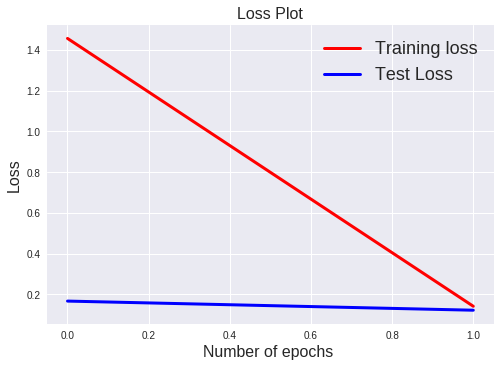

In [0]:
saveToFile = "dropout07_loss"
# plt.figure(figsize=[8,6])
plt.plot(results.history['loss'],'r',linewidth=3.0)
plt.plot(results.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Test Loss'],fontsize=18)
plt.xlabel('Number of epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Plot',fontsize=16)
plt.savefig("wykresy/" + saveToFile)


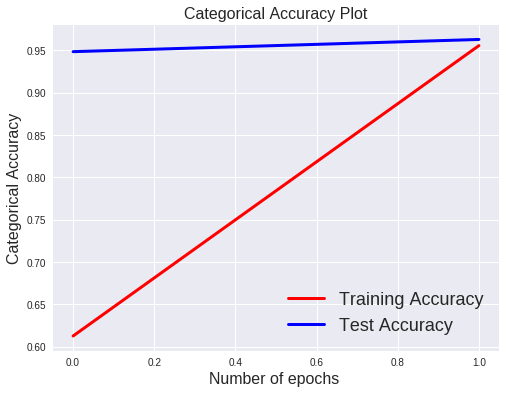

In [0]:
saveToFile = "dropout07_accuracy"
plt.figure(figsize=[8,6])
plt.plot(results.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(results.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Test Accuracy'],fontsize=18)
plt.xlabel('Number of epochs ',fontsize=16)
plt.ylabel('Categorical Accuracy',fontsize=16)
plt.title('Categorical Accuracy Plot',fontsize=16)
plt.savefig("wykresy/" + saveToFile)

# Wczesne zatrzymanie uczenia

In [0]:

# import os
# from collections import Counter

# import cv2
# import matplotlib.pyplot as plt
# import numpy as np
# from keras.layers import Dense
# from keras.models import Sequential
# from skimage import feature
# from skimage.util import random_noise
# from sklearn.metrics import roc_curve, auc
# from sklearn.model_selection import train_test_split

# from keras.applications.vgg16 import VGG16
# # from keras.preprocessing.image import load_img
# from keras import layers
# from keras import optimizers
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.models import Model, load_model
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, \
#     merge, Reshape, Activation, InputLayer
# from matplotlib import pyplot

# vgg_conv_info = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
#
# vgg_conv_info.

model = Sequential()

model.add(layers.InputLayer((100, 100, 3)))
model.add(layers.Convolution2D(64, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block1_conv1'))
model.add( layers.Convolution2D(64, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block1_conv2'))
model.add( layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

# Block 2
model.add( layers.Convolution2D(128, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block2_conv1'))
model.add( layers.Convolution2D(128, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block2_conv2'))
model.add( layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

# Block 3
model.add( layers.Convolution2D(256, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block3_conv1'))
model.add( layers.Convolution2D(256, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block3_conv2'))
model.add( layers.Convolution2D(256, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block3_conv3'))
model.add( layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

# Block 4
model.add( layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block4_conv1'))
model.add( layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block4_conv2'))
model.add( layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block4_conv3'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

# Block 5
model.add(layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block5_conv1'))
model.add(layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block5_conv2'))
model.add( layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block5_conv3'))
model.add( layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

model.add(layers.Flatten())
# tmp_model_working.add(Dropout(0.3))
model.add(layers.Dense(71, activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 25, 25, 256)       295168    
__________

In [16]:
# Konfiguracja sieci i danych
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['categorical_accuracy'])

cb_early = [EarlyStopping(monitor='val_loss', patience=2, min_delta=0.07)]

results = model.fit(x_teach, np.asarray(y_teach), epochs=20, batch_size = 100, validation_data=(x_test, np.asarray(y_test)),
                    verbose=1,callbacks= cb_early)
#model.fit(x_teach,np.asarray(y_teach),batch_size=100,epochs=3,validation_data=(x_test, np.asarray(y_test)))


Train on 28925 samples, validate on 13877 samples
Epoch 1/20
28925/28925 [==============================] - 215s 7ms/step - loss: 0.0241 - categorical_accuracy: 0.9920 - val_loss: 0.2144 - val_categorical_accuracy: 0.9612
Epoch 2/20
28925/28925 [==============================] - 213s 7ms/step - loss: 0.0175 - categorical_accuracy: 0.9956 - val_loss: 0.2829 - val_categorical_accuracy: 0.9377
Epoch 3/20
28925/28925 [==============================] - 214s 7ms/step - loss: 0.0133 - categorical_accuracy: 0.9961 - val_loss: 0.1123 - val_categorical_accuracy: 0.9712
Epoch 4/20
28925/28925 [==============================] - 213s 7ms/step - loss: 0.0094 - categorical_accuracy: 0.9972 - val_loss: 0.1092 - val_categorical_accuracy: 0.9779
Epoch 5/20
28925/28925 [==============================] - 213s 7ms/step - loss: 1.4533e-05 - categorical_accuracy: 1.0000 - val_loss: 0.0949 - val_categorical_accuracy: 0.9820


In [0]:
model_name = "early_stopping_delta007.hdf5"
model.save(model_name)

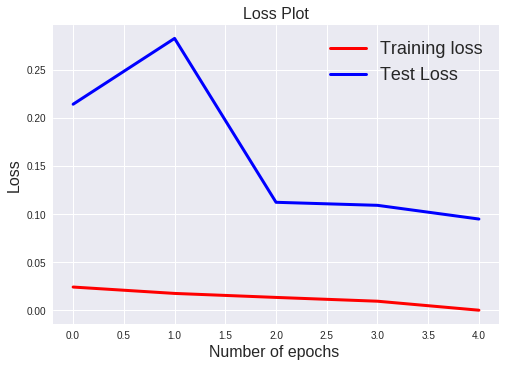

In [18]:
saveToFile = "early_stopping_delta007_loss"
# plt.figure(figsize=[8,6])
plt.plot(results.history['loss'],'r',linewidth=3.0)
plt.plot(results.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Test Loss'],fontsize=18)
plt.xlabel('Number of epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Plot',fontsize=16)
plt.savefig("wykresy/" + saveToFile)


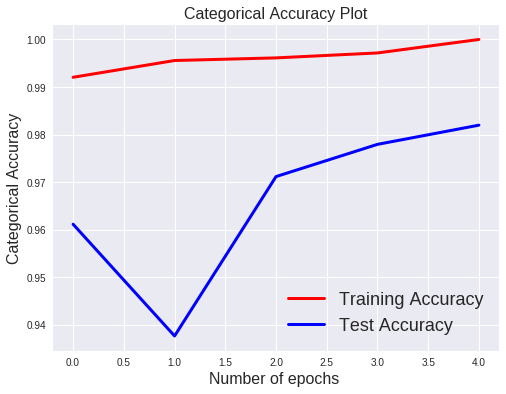

In [19]:
saveToFile = "early_stopping_delta007_accuracy"
plt.figure(figsize=[8,6])
plt.plot(results.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(results.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Test Accuracy'],fontsize=18)
plt.xlabel('Number of epochs ',fontsize=16)
plt.ylabel('Categorical Accuracy',fontsize=16)
plt.title('Categorical Accuracy Plot',fontsize=16)
plt.savefig("wykresy/" + saveToFile)

In [0]:
# plt.figure(figsize=[8,6])
# plt.plot(results.history['loss'],'r',linewidth=3.0)
# plt.plot(results.history['val_loss'],'b',linewidth=3.0)
# plt.legend(['Training loss', 'Test Loss'],fontsize=18)
# plt.xlabel('Epochs ',fontsize=16)
# plt.ylabel('Loss',fontsize=16)
# plt.title('Loss Curves',fontsize=16)

In [0]:
# vgg_conv_info = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

In [0]:
# # dropout
# tmp_model_working = Sequential()


# # for tmp in vgg_conv_info.layers[:-2]:
# for tmp in vgg_conv_info.layers[:-2]:
# #   weights = tmp.get_weights()
#   tmp_model_working.add(tmp)
# #   tmp.set_weights(weights)

# # trzy różne rozmairy deskryptora
# # tmp_model_working.add(Convolution2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
# # tmp_model_working.add(Convolution2D(512, (5, 5), strides=(1, 1), padding='same', activation='relu'))

# # tmp_model_working.add(Convolution2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
# tmp_model_working.add(Convolution2D(512, (3, 3), padding='same', activation='relu'))

# tmp_model_working.add(MaxPooling2D(pool_size=(2, 2),strides= (2, 2)))

# # # Dodawanie warstw
# tmp_model_working.add(layers.Flatten())
# # tmp_model_working.add(Dropout(0.3))
# tmp_model_working.add(layers.Dense(71, activation='softmax'))

# tmp_model_working.summary()


In [0]:
# # Konfiguracja sieci i danych
# tmp_model_working.compile(loss='categorical_crossentropy',
#               optimizer=optimizers.Adam(lr=0.0001),
#               metrics=['categorical_accuracy'])

In [0]:
#zminić dane trengowe/testpwe
# x_test = x_test_temp
# y_test = y_test_temp
# cb_early = [EarlyStopping()]

# results = tmp_model_working.fit(x_teach, np.asarray(y_teach), epochs=NUM_OF_EPOCH, batch_size=BATH_SIZE, validation_data=(x_test, np.asarray(y_test)),
#                     verbose=1,callbacks= cb)

# tmp_model_working.fit(x_teach,np.asarray(y_teach),batch_size=400,epochs=10,validation_data=(x_test, np.asarray(y_test)))
# results = model.fit(x_teach, np.asarray(y_teach), epochs=NUM_OF_EPOCH, batch_size=BATH_SIZE, validation_data=(x_val, np.asarray(y_val)),
#                     verbose=1,callbacks= cb)

# Wpływ przesłonięcia obrazów

In [0]:

model = Sequential()

model.add(layers.InputLayer((100, 100, 3)))
model.add(layers.Convolution2D(64, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block1_conv1'))
model.add( layers.Convolution2D(64, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block1_conv2'))
model.add( layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

# Block 2
model.add( layers.Convolution2D(128, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block2_conv1'))
model.add( layers.Convolution2D(128, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block2_conv2'))
model.add( layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

# Block 3
model.add( layers.Convolution2D(256, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block3_conv1'))
model.add( layers.Convolution2D(256, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block3_conv2'))
model.add( layers.Convolution2D(256, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block3_conv3'))
model.add( layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

# Block 4
model.add( layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block4_conv1'))
model.add( layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block4_conv2'))
model.add( layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block4_conv3'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

# Block 5
model.add(layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block5_conv1'))
model.add(layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block5_conv2'))
model.add( layers.Convolution2D(512, (3, 3),
                         activation='relu',
                         padding='same',
                         name='block5_conv3'))
model.add( layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

model.add(layers.Flatten())
# tmp_model_working.add(Dropout(0.3))
model.add(layers.Dense(71, activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 25, 25, 256)       295168    
__________

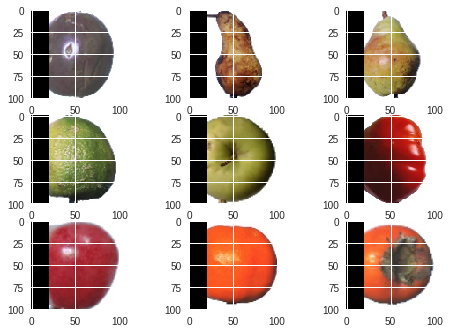

In [0]:
#tu jest parametr do zmiany liczby procentów zaciemnienia obrazu - teraz jest 40 procent
percent = 20
datagennewnew_rot = ImageDataGenerator(fill_mode='nearest')
x_teach_noise = np.copy(x_teach)

for x in range(0, x_teach_noise.shape[0]):
    img = np.reshape(x_teach_noise[x], (100, 100, 3))
    for h in range(img.shape[0]):
        for j in range(img.shape[1]):
            if h < percent:
                img[j, h] = 0

datagennewnew_rot.fit(x_teach_noise)
for X_batch, y_batch in datagennewnew_rot.flow(x_teach_noise, y_teach, batch_size=9):
    for i in range(0, 9):
        # img = np.reshape(X_batch[i], (100, 100, 3))
        # for h in range(img.shape[0]):
        #     for j in range(img.shape[1]):
        #         if h < percent:
        #             img[j, h] = 0
        pyplot.subplot(330 + 1 + i)
        bgr = X_batch[i].reshape(100, 100, 3).astype('uint8')
        rgb = bgr[...,::-1]
        pyplot.imshow(rgb)
    pyplot.show()
    break

In [0]:
# Konfiguracja sieci i danych
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['categorical_accuracy'])

results = model.fit(x_teach, np.asarray(y_teach), epochs=2, batch_size = 100, validation_data=(x_test, np.asarray(y_test)),
                    verbose=1)

Train on 28925 samples, validate on 13877 samples
Epoch 1/2
28925/28925 [==============================] - 245s 8ms/step - loss: 0.6780 - categorical_accuracy: 0.8223 - val_loss: 0.1683 - val_categorical_accuracy: 0.9533
Epoch 2/2
28925/28925 [==============================] - 225s 8ms/step - loss: 0.0531 - categorical_accuracy: 0.9829 - val_loss: 0.1974 - val_categorical_accuracy: 0.9338


In [0]:
model_name = "przesloniecie20.hdf5"
model.save(model_name)

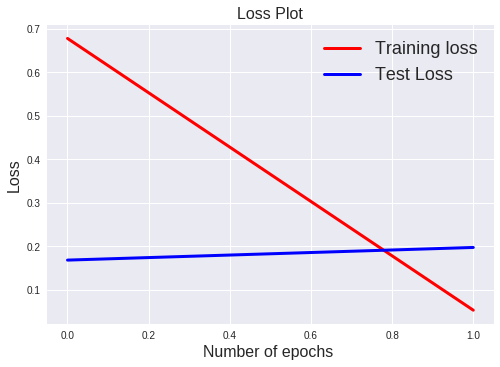

In [0]:
saveToFile = "przesloniecie20_loss"
# plt.figure(figsize=[8,6])
plt.plot(results.history['loss'],'r',linewidth=3.0)
plt.plot(results.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Test Loss'],fontsize=18)
plt.xlabel('Number of epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Plot',fontsize=16)
plt.savefig("wykresy/" + saveToFile)


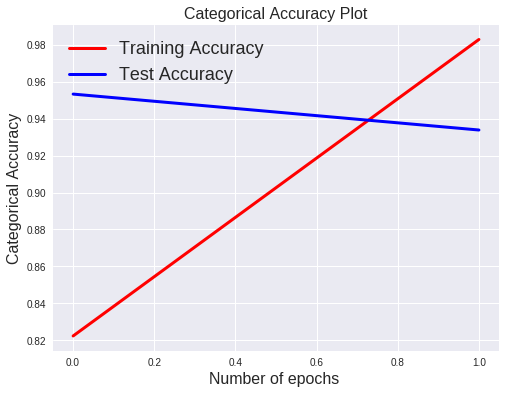

In [0]:
saveToFile = "przesloniecie20_accuracy"
plt.figure(figsize=[8,6])
plt.plot(results.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(results.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Test Accuracy'],fontsize=18)
plt.xlabel('Number of epochs ',fontsize=16)
plt.ylabel('Categorical Accuracy',fontsize=16)
plt.title('Categorical Accuracy Plot',fontsize=16)
plt.savefig("wykresy/" + saveToFile)

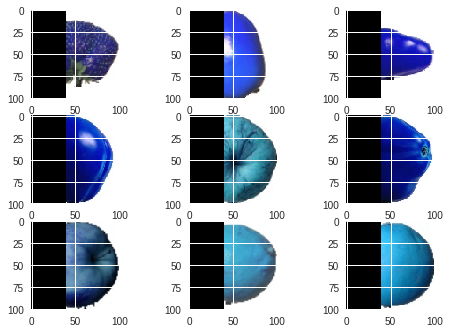

In [0]:
# percent = 40
# datagennewnew_rot = ImageDataGenerator(fill_mode='nearest')
# datagennewnew_rot.fit(x_teach)
# for X_batch, y_batch in datagennewnew_rot.flow(x_teach, y_teach, batch_size=9):
#     for i in range(0, 9):
#         img = np.reshape(X_batch[i], (100, 100, 3))
#         for h in range(img.shape[0]):
#             for j in range(img.shape[1]):
#                 if h < percent:
#                     img[j, h] = 0
#         pyplot.subplot(330 + 1 + i)
#         pyplot.imshow(X_batch[i].reshape(100, 100, 3).astype('uint8'))
#     pyplot.show()
#     break

# informacje o sieci VGG

In [0]:
tmp_model_working = Sequential()

tmp_model_working222 = Sequential()
# tmp_model_working222.add(Convolution2D(3, (3, 3),strides=(1, 1), padding='same', activation='relu', input_shape=(100, 100, 3)))
tmp_model_working222.add(vgg_conv_info.layers[1])
# tmp_model_working222.add(vgg_conv_info.layers[2])

print(tmp_model_working222.layers[0].get_config())
# tmp_model_working222.summary()
print("Ppppppp")
# tmp_model_working.add(InputLayer(input_shape=(100, 100, 3)))
# tmp_model_working.add(Input(shape=(100, 100, 3)))
# tmp_model_working.add(InputLayer(input_shape=(100, 100, 3)))
# tmp_model_working.add(Input(shape=(100, 100, 3)))

# tmp_model_working.add(Dense(3, input_shape=(100, 100, 3)))
# tmp_model_working.add(Convolution2D(3, (3, 3),strides=(1, 1), padding='same', activation='relu', input_shape=(100, 100, 3),                       
#                                     data_format= 'channels_last', dilation_rate= (1, 1), use_bias= True))
tmp_model_working.add(Convolution2D(64, (3, 3),strides=(1, 1), padding='same', activation='relu', input_shape=(100, 100, 3),                       
                                    data_format= 'channels_last'))
for tmp in vgg_conv_info.layers[2:]:
#   print(tmp)
#   print("aaaaaaa")
  tmp_model_working.add(tmp)
#   print("bbbbbbbbb")

tmp_model_working.summary()

{'name': 'block1_conv1', 'trainable': True, 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
Ppppppp
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 5

In [0]:
# tmp_model_working = Sequential()
# vgg_conv_info.inputs
# for tmp in vgg_conv_info.layers:
#   tmp_model_working.add(tmp)
# #   tmp.get_config().

# cfg = vgg_conv_info.layers[1].get_config()

# qqqq = vgg_conv_info.get_config()
# print(qqqq)
# print(qqqq.get('layers'))
# qqqq['class_name'] = 'InputLayer2222'
# print(qqqq.get('layers'))

# print(cfg)
# cfg['kernel_size']=(5,5)
# tmp_model_working.layers[1].from_config(cfg)
# tmp_model_working.compile()
# print(cfg)

# tmp_model_working.get_config()
  
# tmp_model_working.summary()

{'name': 'vgg16', 'layers': [{'name': 'input_2', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 100, 100, 3), 'dtype': 'float32', 'sparse': False, 'name': 'input_2'}, 'inbound_nodes': []}, {'name': 'block1_conv1', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv1', 'trainable': True, 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'inbound_nodes': [[['input_2', 0, 0, {}]]]}, {'name': 'block1_conv2', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv2', 'trainable': True, 'filters': 64, 'kernel_size'

In [0]:
modeltmpttmp = Sequential()
modeltmpttmp.add(Convolution2D(64, (3, 3), padding='same', activation='relu', input_shape=(100, 100, 3)))
modeltmpttmp.add(Convolution2D(64, (3, 3), activation='relu'))

# modeltmpttmp.add(Dropout(dropout))
modeltmpttmp.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
modeltmpttmp.add(Convolution2D(64, (3, 3), activation='relu'))
modeltmpttmp.add(MaxPooling2D(pool_size=(2, 2)))

# modeltmpttmp.add(Dropout(dropout))
modeltmpttmp.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
modeltmpttmp.add(Convolution2D(128, (3, 3), activation='relu'))

# modeltmpttmp.add(Dropout(dropout))
modeltmpttmp.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
modeltmpttmp.add(Convolution2D(128, (3, 3), activation='relu'))
modeltmpttmp.add(MaxPooling2D(pool_size=(2, 2)))

# modeltmpttmp.add(Dropout(dropout))
modeltmpttmp.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
modeltmpttmp.add(Convolution2D(256, (3, 3), activation='relu'))

# modeltmpttmp.add(Dropout(dropout))
modeltmpttmp.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
modeltmpttmp.add(Convolution2D(256, (3, 3), activation='relu'))
modeltmpttmp.add(MaxPooling2D(pool_size=(2, 2)))

# modeltmpttmp.add(Dropout(dropout))
modeltmpttmp.add(Convolution2D(512, (3, 3), padding='same', activation='relu'))
modeltmpttmp.add(Convolution2D(512, (3, 3), activation='relu'))

# modeltmpttmp.add(Dropout(dropout))
modeltmpttmp.add(Convolution2D(512, (3, 3), padding='same', activation='relu'))
modeltmpttmp.add(Convolution2D(512, (3, 3), activation='relu'))

modeltmpttmp.add(Flatten())

# modeltmpttmp.add(Dropout(dropout))
modeltmpttmp.add(Dense(512, activation='relu'))
modeltmpttmp.add(Dense(50, activation='softmax'))

In [0]:
modeltmpttmp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 98, 98, 64)        36928     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 98, 98, 64)        36928     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 96, 96, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 48, 48, 128)       73856     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 46, 46, 128)       147584    
__________

In [0]:
print(vgg_conv_info.layers[1].kernel_size)


In [0]:
vgg_conv_info.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

#TESTYMOJE_MCZ

In [0]:
ls

best_VGG_based_model_01.hdf5               dataX-test.npy
best_VGG_based_model_no_trained_rand.hdf5  dataY-teach.npy
best_VGG_based_model_no_trined.hdf5        dataY-test.npy
best_VGG_based_model_rotated_images.hdf5   wykresy/
dataX-teach.npy


In [0]:
pwd

'/content'

In [0]:
#!mkdir wykresy

In [0]:
del model
del vgg_conv 

In [0]:
model

NameError: ignored

#ODPALANIE PO CRASHU

In [4]:
cd /content/drive/snr_projekt/

/content/drive/snr_projekt


In [0]:
ls -la

total 16
drwxr-xr-x 3 root root 4096 Jan 21 17:26 ./
drwxr-xr-x 1 root root 4096 Jan 21 17:16 ../
drwxr-xr-x 2 root root 4096 Jan 21 17:26 drive/


In [0]:
x_teach

NameError: ignored

In [5]:


import os
from collections import Counter

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from skimage import feature
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

from keras.applications.vgg16 import VGG16
# from keras.preprocessing.image import load_img
from keras import layers
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation, InputLayer
from matplotlib import pyplot
from skimage.util import random_noise

def check_numpy_set_exist(name):
    if os.path.isfile("dataX-" + name + ".npy") and os.path.isfile("dataY-" + name + ".npy"):
        return True
    return False

def load_numpy_set(name):
    x = np.load("dataX-" + name + ".npy")
    y = np.load("dataY-" + name + ".npy")
    return x, y

def make_id_class_dictionary(y_val):
    # make dictionary of classes
    y_val.sort()
    y_val = Counter(y_val).keys()

    class_id = {}
    temp_list_id = []
    count = 1

    for i in y_val:
        temp_list_id.append((i, count))
        count += 1

    for word, _id in temp_list_id:
        class_id[word] = _id
    print(class_id)

    return class_id
  
def cvt2_id_class_list(dictionary_class_id, word_list):
    # covert word list of class to id list of class
    y_teach = []
    for i in word_list:
        y_teach.append(dictionary_class_id[i])
    return y_teach

def cv2_id_class_as_vector(y_val_temp, num_of_class):
    y_val = []
    for i in y_val_temp:
        y = [0] * num_of_class
        y[i - 1] = 1
        y_val.append(y)
    np.asarray(y_val)
    return y_val
 


LR_ADAMA = 0.000125


# if not check_numpy_set_exist("teach"):
#   create_numpy_set(TRAINING_PATH, "teach")
#   print("Dane trengowe tworzone")
print("Dane trengowe wczytywanie rozpoczęte")
x_teach, y_teach = load_numpy_set("teach")
print("Dane trengowe wczytane")
# if not check_numpy_set_exist("test"):
#   create_numpy_set(TEST_PATH, "test")
#   print("Dane testowe tworzone")
  
print("Dane testowe wczytywanie rozpoczęte")
x_test, y_test_temp = load_numpy_set("test")
print("Dane testowe wczytane")
y_test_temp_copy = y_test_temp.copy()

# random Split Data set to teach
x_teach, x_val, y_teach_temp1, y_val_temp1 = train_test_split(x_teach, y_teach, test_size=0.3, random_state=42)
print("Dane podzielone na zbiór trteningowy i walidacyjny")

# number of class in set
num_of_class = len(set(y_test_temp_copy))

# make idClasses
id_class_dictionary = make_id_class_dictionary(y_test_temp_copy)

# convert from wordList to numberList Of class
y_teach_temp2 = cvt2_id_class_list(id_class_dictionary, y_teach_temp1)
y_val_temp2 = cvt2_id_class_list(id_class_dictionary, y_val_temp1)

# get final representation of labels as vector ex. [0 0 0 0 ..... 0 1 0 0 0] - outputs of network
y_val = cv2_id_class_as_vector(y_val_temp2, num_of_class)
y_teach = cv2_id_class_as_vector(y_teach_temp2, num_of_class)


#zbiór testowy
y_test_tmp = cvt2_id_class_list(id_class_dictionary, y_test_temp)
y_test = cv2_id_class_as_vector(y_test_tmp, num_of_class)
#zmiana nazw zbioru testowego
# x_test = x_test_temp

x_test_temp=x_test


Using TensorFlow backend.


Dane trengowe wczytywanie rozpoczęte
Dane trengowe wczytane
Dane testowe wczytywanie rozpoczęte
Dane testowe wczytane
Dane podzielone na zbiór trteningowy i walidacyjny
{'Apple Braeburn': 1, 'Apple Golden': 2, 'Apple Granny Smith': 3, 'Apple Red': 4, 'Apple Red Delicious': 5, 'Apple Red Yellow': 6, 'Apricot': 7, 'Avocado': 8, 'Avocado ripe': 9, 'Banana': 10, 'Banana Red': 11, 'Cactus fruit': 12, 'Cantaloupe': 13, 'Carambula': 14, 'Cherry': 15, 'Cherry Rainier': 16, 'Cherry Wax Black': 17, 'Cherry Wax Red': 18, 'Cherry Wax Yellow': 19, 'Clementine': 20, 'Cocos': 21, 'Dates': 22, 'Granadilla': 23, 'Grape Pink': 24, 'Grape White': 25, 'Grapefruit Pink': 26, 'Grapefruit White': 27, 'Guava': 28, 'Huckleberry': 29, 'Kaki': 30, 'Kiwi': 31, 'Kumquats': 32, 'Lemon': 33, 'Lemon Meyer': 34, 'Limes': 35, 'Lychee': 36, 'Mandarine': 37, 'Mango': 38, 'Maracuja': 39, 'Melon Piel de Sapo': 40, 'Mulberry': 41, 'Nectarine': 42, 'Orange': 43, 'Papaya': 44, 'Passion Fruit': 45, 'Peach': 46, 'Peach Flat': 4

In [0]:
#LR_ADAMA = 0.000125

In [0]:
LR_ADAMA

0.000125